In [ ]:
import py7zr
import polars as pl
import json
import io

import requests
from io import BytesIO

import requests

# Download file directly from GitHub into memory
# https://github.com/linouk23/NBA-Player-Movements/blob/master/data/2016.NBA.Raw.SportVU.Game.Logs/01.01.2016.CHA.at.TOR.7z

url = "https://raw.githubusercontent.com/linouk23/NBA-Player-Movements/f7d4cf2c7e607029abfd5715a0d4073bedae328e/data/2016.NBA.Raw.SportVU.Game.Logs/01.01.2016.CHA.at.TOR.7z"

response = requests.get(url)
response.raise_for_status()

with py7zr.SevenZipFile(BytesIO(response.content), "r") as archive:
    data = archive.readall()

    file_names = list(data.keys())
    file_name = file_names[0]
    content = data[file_name]

    if isinstance(content, io.BytesIO):
        content_bytes = content.read()
    elif isinstance(content, bytes):
        content_bytes = content
    else:
        raise ValueError("Unexpected file content type")

    try:
        json_data = json.loads(content_bytes.decode("utf-8"))
        print("JSON Loaded Successfully!")
    except json.JSONDecodeError as e:
        print("Error decoding JSON:", e)
        json_data = None

['0021500492.json']
JSON Loaded Successfully!


### Parse Data

Below we parse the data into `BasketballObject` and `BasketballPlayer` objects. 

In [54]:
from dataclasses import dataclass
from datetime import datetime, timedelta

from typing import Union, List

team_ids = {
    1610612737: "ATL",
    1610612738: "BOS",
    1610612751: "BKN",
    1610612766: "CHA",
    1610612741: "CHI",
    1610612739: "CLE",
    1610612742: "DAL",
    1610612743: "DEN",
    1610612765: "DET",
    1610612744: "GSW",
    1610612745: "HOU",
    1610612754: "IND",
    1610612746: "LAC",
    1610612747: "LAL",
    1610612763: "MEM",
    1610612748: "MIA",
    1610612749: "MIL",
    1610612750: "MIN",
    1610612740: "NOP",
    1610612752: "NYK",
    1610612760: "OKC",
    1610612753: "ORL",
    1610612755: "PHI",
    1610612756: "PHX",
    1610612757: "POR",
    1610612758: "SAC",
    1610612759: "SAS",
    1610612761: "TOR",
    1610612762: "UTA",
    1610612764: "WAS",
}

In [149]:
class Constant:
    BALL = "ball"


@dataclass
class BasketballObject:
    team_id: Union[int, str]
    id: Union[int, str]
    x: float
    y: float
    z: float
    quarter: int
    game_clock: timedelta
    shot_clock: timedelta
    event_id: int
    frame_id: int


@dataclass
class BasketballPlayer:
    id: Union[int, str]
    number: int
    first_name: str
    last_name: str

In [150]:
def __parse_players(event) -> List[BasketballPlayer]:
    home_players = event["home"]["players"]
    guest_players = event["visitor"]["players"]

    return [
        BasketballPlayer(
            id=player["playerid"],
            number=int(player["jersey"]),
            last_name=player["lastname"],
            first_name=player["firstname"],
        )
        for player in home_players + guest_players
    ]


def __parse_moment(moment, frame_id, event_id) -> List[BasketballObject]:
    quarter = moment[0]  # Hardcoded position for quarter in json
    game_clock = moment[2]  # Hardcoded position for game_clock in json
    game_clock = 0.0 if game_clock is None else game_clock
    shot_clock = moment[3]  # Hardcoded position for shot_clock in json
    shot_clock = 0.0 if shot_clock is None else shot_clock
    ball = moment[5][0]  # Hardcoded position for ball in json
    players = moment[5][1:]  # Hardcoded position for players in json

    objects = list()
    for player in players:
        objects.append(
            BasketballObject(
                team_id=player[0],
                id=player[1],
                x=player[2],
                y=player[3],
                z=0.0,
                quarter=quarter,
                game_clock=timedelta(seconds=game_clock),
                shot_clock=timedelta(seconds=shot_clock),
                event_id=int(event_id),
                frame_id=frame_id,
            )
        )

    objects.append(
        BasketballObject(
            team_id=Constant.BALL,
            id=Constant.BALL,
            x=ball[2],
            y=ball[3],
            z=ball[4],
            quarter=quarter,
            game_clock=timedelta(seconds=game_clock),
            shot_clock=timedelta(seconds=shot_clock),
            event_id=int(event_id),
            frame_id=frame_id,
        )
    )
    return objects

In [ ]:
events = json_data["events"]
event = json_data["events"][0]
moment = event["moments"]

players = None

In [210]:
frame_list = list()
frame_id = 1
for event in events:
    if players is None:
        players = __parse_players(event)

    for moment in event["moments"]:
        m = __parse_moment(moment, frame_id=frame_id, event_id=event["eventId"])
        frame_list.extend(m)
        frame_id += 1

### Polars

Above we loop over all the events and create list of frame objects. Each item in the list is an object (player or ball)

Below we create a Polars dataframe from this list and we plot a single frame of data.

In [212]:
data = pl.DataFrame(frame_list)

In [213]:
pl.Config(tbl_rows=50)
frame = data.filter(
    # ((pl.col("event_id") == 2)) &
    (pl.col("frame_id") == 150)
)

In [214]:
frame

team_id,id,x,y,z,quarter,game_clock,shot_clock,event_id,frame_id
str,str,f64,f64,f64,i64,duration[μs],duration[μs],i64,i64
"""1610612761""","""2449""",5.62772,5.87473,0.0,1,11m 45s 300ms,8s 540ms,1,150
"""1610612761""","""201960""",5.73374,43.28594,0.0,1,11m 45s 300ms,8s 540ms,1,150
"""1610612761""","""200768""",29.07003,39.29628,0.0,1,11m 45s 300ms,8s 540ms,1,150
"""1610612761""","""201942""",22.24552,21.64748,0.0,1,11m 45s 300ms,8s 540ms,1,150
"""1610612761""","""202685""",9.67097,29.11568,0.0,1,11m 45s 300ms,8s 540ms,1,150
"""1610612766""","""101107""",6.24964,5.04915,0.0,1,11m 45s 300ms,8s 540ms,1,150
"""1610612766""","""201587""",4.40631,32.44555,0.0,1,11m 45s 300ms,8s 540ms,1,150
"""1610612766""","""202689""",10.75216,25.029,0.0,1,11m 45s 300ms,8s 540ms,1,150
"""1610612766""","""203469""",7.89709,28.3344,0.0,1,11m 45s 300ms,8s 540ms,1,150


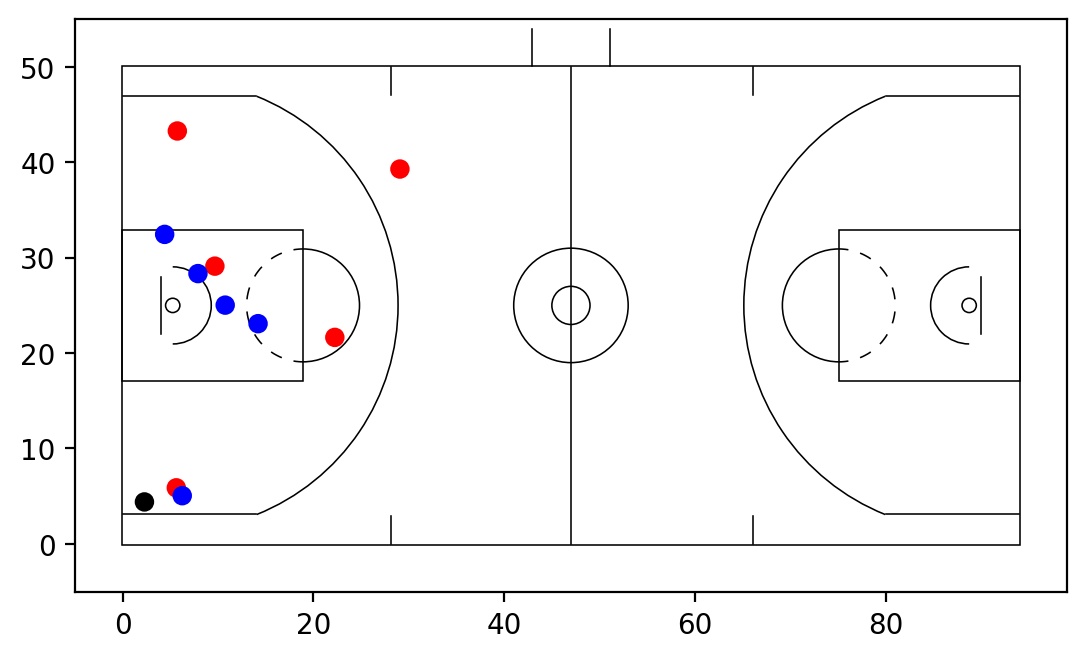

In [215]:
from mplbasketball import Court

import numpy as np

court = Court(court_type="nba", origin="bottom-left", units="ft")
fig, ax = court.draw(showaxis=True)

colors = np.where(
    frame["team_id"] == "1610612761",
    "red",
    np.where(frame["team_id"] == "1610612766", "blue", "black"),
)

ax.scatter(frame["x"], frame["y"], color=colors)

### Issues

The main issues I'm trying to resolve right now:
- I don't understand how the shot clock works and why we seem to be missing frames? Shot clock doesn't start at 24s at start of the game
- Current frame (frame_id=150) and subsequent frame (frame_id=151) are very far from each other. 
- I want to synchronize play by play data such that we know which sequence of play lead to a turn over, a 2pt attempt or a 3pt attempt. Play-by-play data from this season (2015-16) taken from [Kaggle](https://www.kaggle.com/datasets/schmadam97/nba-playbyplay-data-20182019?resource=download) can be found in assets/NBA_PBP_2015-16.csv.zip. I don't uderstand the relationship between this data and the tracking data because of the above mentioned game clock / time clock "issue". 
- This play-by-play data might take some effort to sync because the team symbols aren't 100 the same (minor issue) and because the Kaggle dataset has some badly parsed names. We might need to use the script in the Kaggle (GitHub link) to rescrape the data a bit better